### ***Step 4 Evaluation full features***

#### ***Load Notebook basics***

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt

from sklearn.model_selection import (
    train_test_split, StratifiedKFold, cross_val_score, learning_curve
)
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import (
    roc_auc_score, balanced_accuracy_score, f1_score,
    average_precision_score, recall_score, brier_score_loss
)
from sklearn.calibration import calibration_curve

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


In [2]:
PROJECT_ROOT = Path.cwd().parent
DATA_DIR = PROJECT_ROOT / "data"

df_gex = pd.read_csv(DATA_DIR / "mammacarcinoma_gex.csv")
df_pat = pd.read_csv(DATA_DIR / "mammacarcinoma_pat.csv")

# Merge: 1 row = 1 patient
df_full = df_pat.merge(df_gex, on="patient_id", how="inner")

gene_cols = [c for c in df_gex.columns if c != "patient_id"]

print("Merged shape:", df_full.shape)
print("Number of gene features:", len(gene_cols))


Merged shape: (327, 6391)
Number of gene features: 6384


In [3]:
pre = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

models = {
    "LogReg": Pipeline([
        ("pre", pre),
        ("model", LogisticRegression(
            max_iter=5000,
            class_weight="balanced",
            random_state=RANDOM_STATE
        ))
    ]),
    "RF": Pipeline([
        ("pre", pre),
        ("model", RandomForestClassifier(
            n_estimators=500,
            class_weight="balanced_subsample",
            random_state=RANDOM_STATE,
            n_jobs=-1
        ))
    ]),
    "kNN": Pipeline([
        ("pre", pre),
        ("model", KNeighborsClassifier(
            n_neighbors=11,
            weights="distance"
        ))
    ]),
}
#create models

In [4]:
def make_split_full(df_full, gene_cols, target, test_size=0.2):
    df_t = df_full.dropna(subset=[target]).copy()
    df_t[target] = df_t[target].astype(int)

    X = df_t[gene_cols]
    y = df_t[target]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=test_size,
        random_state=RANDOM_STATE,
        stratify=y
    )
    return X_train, X_test, y_train, y_test
# Again split Data

#### ***Evaluation metrics***

In [5]:
def eval_test_metrics(models, X_train, y_train, X_test, y_test, target):
    rows = []

    for name, pipe in models.items():
        pipe.fit(X_train, y_train)

        y_pred = pipe.predict(X_test)

        if hasattr(pipe, "predict_proba"):
            y_score = pipe.predict_proba(X_test)[:, 1]
        else:
            y_score = pipe.decision_function(X_test)

        rows.append({
            "target": target,
            "model": name,
            "roc_auc": roc_auc_score(y_test, y_score) if len(np.unique(y_test)) > 1 else np.nan,
            "balanced_acc": balanced_accuracy_score(y_test, y_pred),
            "f1": f1_score(y_test, y_pred, zero_division=0),
            "avg_precision": average_precision_score(y_test, y_score) if len(np.unique(y_test)) > 1 else np.nan,
            "recall_0": recall_score(y_test, y_pred, pos_label=0, zero_division=0),
            "recall_1": recall_score(y_test, y_pred, pos_label=1, zero_division=0),
        })

    return pd.DataFrame(rows)
    
#define evaluation metrics

In [6]:
def eval_cv_stability(models, X_train, y_train, target, n_splits=5):
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)

    scoring = {
        "roc_auc": "roc_auc",
        "balanced_acc": "balanced_accuracy",
        "f1": "f1",
        "avg_precision": "average_precision",
    }

    rows = []

    for name, pipe in models.items():
        for metric, scorer in scoring.items():
            scores = cross_val_score(
                pipe, X_train, y_train,
                cv=cv, scoring=scorer, n_jobs=-1
            )
            rows.append({
                "target": target,
                "model": name,
                "metric": metric,
                "cv_mean": scores.mean(),
                "cv_std": scores.std(ddof=1),
            })

    return pd.DataFrame(rows)


In [7]:
def eval_brier(models, X_train, y_train, X_test, y_test, target):
    rows = []

    for name, pipe in models.items():
        pipe.fit(X_train, y_train)

        if hasattr(pipe, "predict_proba"):
            y_score = pipe.predict_proba(X_test)[:, 1]
        else:
            s = pipe.decision_function(X_test)
            y_score = 1 / (1 + np.exp(-s))

        rows.append({
            "target": target,
            "model": name,
            "brier": brier_score_loss(y_test, y_score),
            "pos_rate_test": float(y_test.mean()),
            "N_test": int(len(y_test))
        })

    return pd.DataFrame(rows)


In [8]:
#brier and metrics
targets = ["er", "node", "relapse"]

test_tables = []
cv_tables = []
brier_tables = []

for target in targets:
    print(f"\n=== Target: {target} ===")

    X_train, X_test, y_train, y_test = make_split_full(
        df_full, gene_cols, target
    )

    print(f"N_train={len(y_train)}, N_test={len(y_test)}, PosRate_test={y_test.mean():.3f}")

    test_tables.append(
        eval_test_metrics(models, X_train, y_train, X_test, y_test, target)
    )

    cv_tables.append(
        eval_cv_stability(models, X_train, y_train, target)
    )

    brier_tables.append(
        eval_brier(models, X_train, y_train, X_test, y_test, target)
    )

df_test_full = pd.concat(test_tables).reset_index(drop=True)
df_cv_full = pd.concat(cv_tables).reset_index(drop=True)
df_brier_full = pd.concat(brier_tables).reset_index(drop=True)

display(df_test_full.round(3))
display(df_cv_full.round(3))
display(df_brier_full.round(4))



=== Target: er ===
N_train=246, N_test=62, PosRate_test=0.855

=== Target: node ===
N_train=197, N_test=50, PosRate_test=0.220

=== Target: relapse ===
N_train=174, N_test=44, PosRate_test=0.409


,target,model,roc_auc,balanced_acc,f1,avg_precision,recall_0,recall_1
0,er,LogReg,0.952,0.833,0.972,0.991,0.667,1.000
1,er,RF,0.966,0.667,0.946,0.994,0.333,1.000
2,er,kNN,0.952,0.611,0.938,0.991,0.222,1.000
3,node,LogReg,0.762,0.598,0.353,0.513,0.923,0.273
4,node,RF,0.802,0.500,0.000,0.526,1.000,0.000
5,node,kNN,0.725,0.500,0.000,0.493,1.000,0.000
6,relapse,LogReg,0.690,0.656,0.519,0.698,0.923,0.389
7,relapse,RF,0.614,0.509,0.100,0.570,0.962,0.056
8,relapse,kNN,0.560,0.545,0.261,0.554,0.923,0.167


,target,model,metric,cv_mean,cv_std
0,er,LogReg,roc_auc,0.925,0.078
1,er,LogReg,balanced_acc,0.776,0.163
2,er,LogReg,f1,0.941,0.033
3,er,LogReg,avg_precision,0.985,0.018
4,er,RF,roc_auc,0.934,0.064
5,er,RF,balanced_acc,0.568,0.051
6,er,RF,f1,0.929,0.010
7,er,RF,avg_precision,0.987,0.014
8,er,kNN,roc_auc,0.881,0.141
9,er,kNN,balanced_acc,0.594,0.083


,target,model,brier,pos_rate_test,N_test
0,er,LogReg,0.0486,0.8548,62
1,er,RF,0.0658,0.8548,62
2,er,kNN,0.0669,0.8548,62
3,node,LogReg,0.1755,0.2200,50
4,node,RF,0.1458,0.2200,50
5,node,kNN,0.1603,0.2200,50
6,relapse,LogReg,0.2496,0.4091,44
7,relapse,RF,0.2337,0.4091,44
8,relapse,kNN,0.2363,0.4091,44


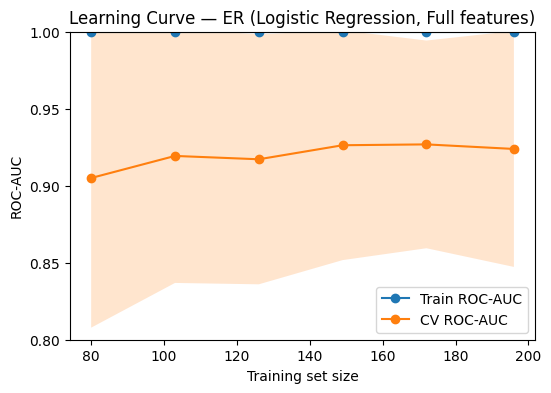

In [9]:
#learning curve 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve, StratifiedKFold

X_train, X_test, y_train, y_test = make_split_full(df_full, gene_cols, "er")

pipe_lr = models["LogReg"]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

n_max = min(len(train_idx) for train_idx, _ in cv.split(X_train, y_train))

start = max(80, 10)   
stop = n_max          

train_sizes_abs = np.linspace(start, stop, 6, dtype=int)

train_sizes, train_scores, val_scores = learning_curve(
    pipe_lr,
    X_train,
    y_train,
    cv=cv,
    scoring="roc_auc",
    train_sizes=train_sizes_abs,
    n_jobs=-1
)

train_mean = train_scores.mean(axis=1)
val_mean   = val_scores.mean(axis=1)
train_std  = train_scores.std(axis=1, ddof=1)
val_std    = val_scores.std(axis=1, ddof=1)

plt.figure(figsize=(6, 4))
plt.plot(train_sizes, train_mean, marker="o", label="Train ROC-AUC")
plt.plot(train_sizes, val_mean, marker="o", label="CV ROC-AUC")
plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.2)
plt.fill_between(train_sizes, val_mean-val_std, val_mean+val_std, alpha=0.2)
plt.xlabel("Training set size")
plt.ylabel("ROC-AUC")
plt.title("Learning Curve — ER (Logistic Regression, Full features)")
plt.legend()
plt.ylim(0.8, 1.0)
plt.yticks(np.arange(0.8, 1.01, 0.05))
plt.savefig(
    "learning curve full.jpeg",
    dpi=300,
    bbox_inches="tight"
)

plt.show()
